# Disease Outbreak Response Decision-making Under Uncertainty: A retrospective analysis of measles in Sao Paulo

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option('max_columns', 20)
pd.set_option('max_rows', 25)

from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
data_dir = "data/"

Import outbreak data

In [3]:
measles_data = pd.read_csv(data_dir+"measles.csv", index_col=0)
measles_data.NOTIFICATION = pd.to_datetime(measles_data.NOTIFICATION)
measles_data.BIRTH = pd.to_datetime(measles_data.BIRTH)
measles_data.ONSET = pd.to_datetime(measles_data.ONSET)

In [4]:
measles_data = measles_data.replace({'DISTRICT': {'BRASILANDIA':'BRAZILANDIA'}})

Sao Paulo population by district

In [5]:
sp_pop = pd.read_csv(data_dir+'sp_pop.csv', index_col=0)

In [6]:
_names = sp_pop.index.values
_names[_names=='BRASILANDIA'] = 'BRAZILANDIA'
sp_pop.set_index(_names, inplace = True)

In [7]:
sp_pop.head()

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249
ARICANDUVA,7732,7730,8373,8956,9182,8531,7813,7365,6551,5554,4887,3858,3320,2449,1611,1723,95635
ARTUR ALVIM,9031,9078,10000,11058,11387,10347,9125,8658,7830,7055,5919,4612,3756,2633,1727,1724,113940


Plot of cumulative cases by district

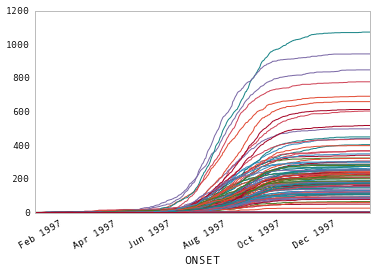

In [8]:
measles_onset_dist = measles_data.groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0)
measles_onset_dist.cumsum().plot(legend=False, grid=False)

In [9]:
total_district_cases = measles_onset_dist.sum()

Top 5 districts by number of cases

In [10]:
totals = measles_onset_dist.sum()
totals.sort(ascending=False)
totals[:5]

DISTRICT
GRAJAU             1074
JARDIM ANGELA       944
CAPAO REDONDO       849
JARDIM SAO LUIZ     778
CAMPO LIMPO         692
dtype: float64

Age distribution of cases, by confirmation status

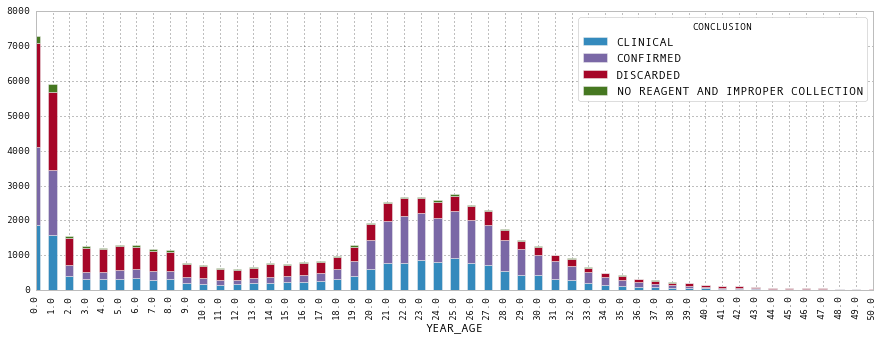

In [11]:
by_conclusion = measles_data.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5))

## Chain Binomial Transmission Model

As a baseline for comparison, we can fit a model to all the clinically-confirmed cases, regardless of lab confirmation status. For this, we will use a simple chain binomial model, which will be fit using MCMC.

This model fits the series of 2-week infection totals as a set of Binomial models:

\\[Pr(I_{t+1} | S_t, p_t) = \text{Bin}(S_t, p_t) \\]

Where the binomial probability is modeled as:

\\[p_t = 1 - \exp\(-\lambda_t\)\\]

\\[\lambda_t = \frac{\beta_t I_t}{N}\\]

We will assume here that the transmission rate is constant over time (and across districts):

\\[\beta_t = \beta_0\\]

which allows the effective reproductive number to be calculated as:

\\[R_t = \frac{\beta S_t}{N}\\]

### Confirmation Sub-model

Rather than assume all clinical cases are true cases, we can adjust the model to account for lab confirmation probability. This is done by including a sub-model that estimates age group-specific probabilities of confirmation, and using these probabilities to estimate the number of lab-confirmed cases. These estimates are then plugged into the model in place of the clinically-confirmed cases.

We specified a structured confirmation model to retrospectively determine the age group-specific probabilities of lab confirmation for measles, conditional on clinical diagnosis. Individual lab confirmation events $c_i$ were modeled as Bernoulli random variables, with the probability of confirmation being allowed to vary by age group:

$$c_i \sim \text{Bernoulli}(p_{a(i)})$$

where $a(i)$ denotes the appropriate age group for the individual indexed by i. There were 16 age groups, the first 15 of which were 5-year age intervals $[0,5), [5, 10), \ldots , [70, 75)$, with the 16th interval including all individuals 75 years and older.

Since the age interval choices were arbitrary, and the confirmation probabilities of adjacent groups likely correlated, we modeled the correlation structure directly, using a multivariate logit-normal model. Specifically, we allowed first-order autocorrelation among the age groups, whereby the variance-covariance matrix retained a tridiagonal structure. 

$$\begin{aligned}
\Sigma = \left[{
\begin{array}{c}
  {\sigma^2} & {\sigma^2 \rho} & 0& \ldots & {0} & {0}  \\
  {\sigma^2 \rho} & {\sigma^2} &  \sigma^2 \rho & \ldots & {0}  & {0} \\
  {0} & \sigma^2 \rho & {\sigma^2} & \ldots & {0} & {0} \\
  \vdots & \vdots & \vdots &  & \vdots & \vdots\\
  {0} & {0} & 0 & \ldots &  {\sigma^2} & \sigma^2 \rho  \\
{0} & {0} & 0 & \ldots & \sigma^2 \rho &  {\sigma^2} 
\end{array}
}\right]
\end{aligned}$$

From this, the confirmation probabilities were specified as multivariate normal on the inverse-logit scale.

$$ \text{logit}(p_a) = \{a\} \sim N(\mu, \Sigma)$$

Priors for the confirmation sub-model were specified by:

$$\begin{aligned}
\mu_i &\sim N(0, 100) \\
\sigma &\sim \text{HalfCauchy}(25) \\
\rho &\sim U(-1, 1)
\end{aligned}$$

Age classes are defined in 5-year intervals.

In [12]:
age_classes = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,100]
measles_data.dropna(subset=['YEAR_AGE'], inplace=True)
measles_data['YEAR_AGE'] = measles_data.YEAR_AGE.astype(int)
measles_data['AGE_GROUP'] = pd.cut(measles_data.AGE, age_classes, right=False)

Lab-checked observations are extracted for use in estimating lab confirmation probability.

In [13]:
CONFIRMED = measles_data.CONCLUSION == 'CONFIRMED'
CLINICAL = measles_data.CONCLUSION == 'CLINICAL'
DISCARDED = measles_data.CONCLUSION == 'DISCARDED'

Extract confirmed and clinical subset, with no missing county information.

In [14]:
lab_subset = measles_data[(CONFIRMED | CLINICAL) & measles_data.COUNTY.notnull()].copy()

In [15]:
age = lab_subset.YEAR_AGE.values
ages = lab_subset.YEAR_AGE.unique()
counties = lab_subset.COUNTY.unique()
y = (lab_subset.CONCLUSION=='CONFIRMED').values

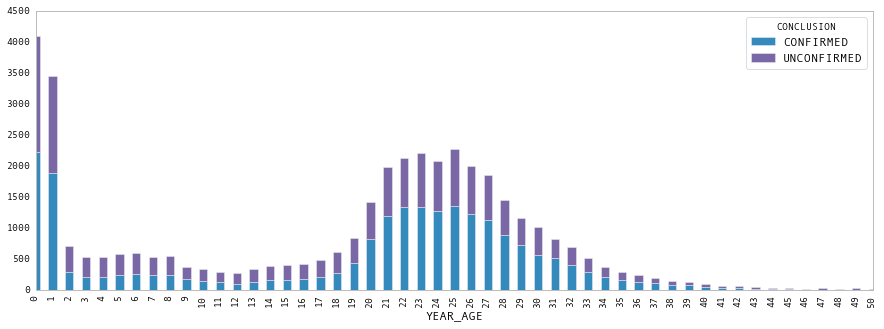

In [16]:
_lab_subset = lab_subset.replace({"CONCLUSION": {"CLINICAL": "UNCONFIRMED"}})
by_conclusion = _lab_subset.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5), grid=False)

In [17]:
lab_subset.shape

(39982, 16)

In [18]:
y.sum()

22097

Proportion of lab-confirmed cases older than 20 years

In [19]:
(measles_data[CONFIRMED].YEAR_AGE>20).mean()

0.60257048468117846

In [20]:
#Extract cases by age and time.

age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.categories.tolist().index(i) for i in age_group])

In [21]:
age_group.categories

Index(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)', '[30, 35)', '[35, 40)', '[40, 45)', '[45, 50)', '[50, 55)', '[55, 60)', '[60, 65)', '[65, 70)', '[70, 75)', '[75, 100)'], dtype='object')

In [22]:
# Get index from full crosstabulation to use as index for each district
dates_index = measles_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().index

In [23]:
unique_districts = measles_data.DISTRICT.dropna().unique()

In [24]:
N = sp_pop.ix[unique_districts, 'Total'].dropna()

In [25]:
sp_districts = N.index.values
len(sp_districts)

93

Compile bi-weekly confirmed and unconfirmed data by Sao Paulo district

In [26]:
all_district_data = []
all_confirmed_cases = []
for d in sp_districts:
    
    # All bi-weekly unconfirmed and confirmed cases
    district_data = lab_subset[lab_subset.DISTRICT==d]
    district_counts_2w = district_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).resample('2W', how='sum')
    all_district_data.append(district_counts_2w)
    
    # All confirmed cases, by district
    confirmed_data = district_data[district_data.CONCLUSION=='CONFIRMED']
    confirmed_counts = confirmed_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).sum()
    all_confirmed_cases.append(confirmed_counts.reindex_axis(measles_data['AGE_GROUP'].unique()).fillna(0))

Time series of cases by district, summarized in 2-week intervals

In [27]:
# Sum over ages for susceptibles
sp_cases_2w = [dist.sum(1) for dist in all_district_data]
len(sp_cases_2w)

93

In [28]:
# Ensure the age groups are ordered
I_obs = np.array([dist.reindex_axis(measles_data['AGE_GROUP'].unique(), 
                            axis=1).fillna(0).values.astype(int) for dist in all_district_data])

In [29]:
I_obs.max()

46

In [30]:
I_obs.sum()

16713

In [31]:
age_groups = measles_data['AGE_GROUP'].unique()
age_groups

array(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 45)', '[45, 50)', '[50, 55)',
       '[55, 60)', '[60, 65)', '[65, 70)', '[70, 75)', '[75, 100)'], dtype=object)

Check shape of data frame

- 93 districts, 28 bi-monthly intervals, 15 age groups

In [32]:
assert I_obs.shape == (93, 28, 16)

### Spatial distance between districts

In [33]:
import geopandas as gpd

shp = gpd.GeoDataFrame.from_file("Sao Paulo/Brazil_full/BRA_adm3.shp")

In [34]:
district_names = N.index.unique()

In [35]:
import trans
shp['district_name'] = shp.NAME_3.apply(
    lambda x: trans.trans(x).upper())

In [36]:
sp_shp = shp[shp.NAME_2=='São Paulo'].set_index('district_name')

In [37]:
centroids = sp_shp.geometry.centroid

In [38]:
distance_matrix = pd.concat([sp_shp.geometry.distance(o) for o in sp_shp.geometry],
                     axis=1)
distance_matrix.columns = sp_shp.index

In [39]:
min_x, min_y = sp_shp.bounds.min()[:2]
max_x, max_y = sp_shp.bounds.max()[2:]

In [40]:
assert (distance_matrix.index == centroids.index).all()

In [41]:
centroid_xy = np.array([[c.x, c.y] for c in sp_shp.geometry.centroid])

Here is an arbitrary distance metric for an arbitrary district, as an example.

In [42]:
_beta = -100
np.exp(_beta*distance_matrix).values.round(2)[0]

array([ 1.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.12,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.04,  0.  ,  0.  ,  0.  ,
        1.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.01,  0.  ,  0.  ,  0.  ,
        0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.18,  0.  ,  0.  ,  0.  ,
        0.  ,  0.04,  1.  ,  0.  ,  0.  ,  0.  ,  0.1 ,  0.01,  0.  ,
        0.  ,  0.19,  0.  ,  0.  ,  0.  ,  0.  ,  0.04,  0.  ,  1.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.11,  0.  ,  1.  ,
        0.02,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.01,  0.  ,  0.02,
        0.03,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.1 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.65,
        0.  ,  0.01,  0.  ,  0.  ,  0.  ,  1.  ])

### Spatial decision model

We attempt to estimate $R_t$ for a truncated subset of the data, to simulate a decision-maker's information during (rather than after) an outbreak. This essentially involves turning part of the time series into missing data, and running the model.

This is an example of creating a mask for data not observed by the decision date.

In [43]:
np.array([np.resize(all_district_data[0].index > '1997-06-15', I_obs[0].T.shape).T]*len(all_district_data))

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True, 

In [44]:
from pymc import MCMC, Matplot
from pymc import (Uniform, DiscreteUniform, Beta, Lambda, Binomial, Normal, Poisson, 
                  NegativeBinomial, observed, negative_binomial_like, Lognormal, Exponential, binomial_like,
                  stochastic, potential, invlogit, TruncatedNormal, Binomial, Gamma)
from pymc import (HalfCauchy, deterministic, MvNormalCov, Bernoulli, potential, Uninformative, Multinomial,
                  rmultinomial, rbinomial, AdaptiveMetropolis)

In [45]:
N*0.07

BRAS               1946.70
BARRA FUNDA         976.36
FREGUESIA DO O    10352.79
CAMBUCI            2197.79
PENHA              8926.26
BRAZILANDIA       16194.50
SANTA CECILIA      5323.22
CASA VERDE         6159.37
CAPAO REDONDO     15690.85
CONSOLACAO         4095.28
...
CIDADE LIDER      7708.26
CAMPO BELO        4932.97
VILA JACUI        8883.07
ITAIM BIBI        6281.24
VILA GUILHERME    3766.28
CURSINO           7358.26
MARSILAC           525.98
GUAIANASES        6481.30
VILA MATILDE      7366.52
PONTE RASA        6993.84
PARI              1176.70
Name: Total, Length: 93, dtype: float64

(array([  3.30200000e+03,   3.53600000e+03,   1.84800000e+03,
          8.28000000e+02,   2.94000000e+02,   1.30000000e+02,
          4.20000000e+01,   1.60000000e+01,   2.00000000e+00,
          2.00000000e+00]),
 array([ 0.00015886,  0.01161896,  0.02307907,  0.03453917,  0.04599927,
         0.05745938,  0.06891948,  0.08037958,  0.09183969,  0.10329979,
         0.1147599 ]),
 <a list of 10 Patch objects>)

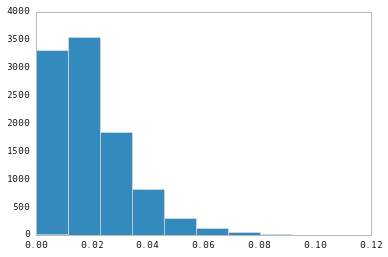

In [46]:
from pymc import rbeta
plt.hist(rbeta(2, 100, 10000))

In [47]:
infected_by_age = I_obs.sum(0).sum(0)
infected_dist = infected_by_age/float(infected_by_age.sum())

Calculate index of first infection, for use in exponential function

In [48]:
def catch(func, handle=lambda e : e, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return -1

first_infection = [catch(lambda: np.where(i > 1)[0][0]) for i in I_obs.sum(2)]

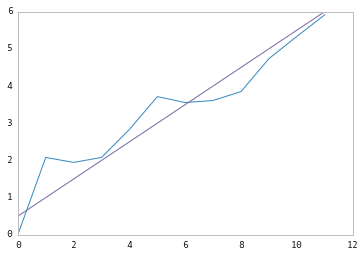

In [49]:
plt.plot(np.log(I_obs.sum(0).sum(1)[:12]))
plt.plot(0.5 + 0.5*np.arange(12))

In [126]:
def measles_model(obs_date, confirmation=True, all_traces=False):
    
    n_districts, n_periods, n_age_groups = I_obs.shape
    
    ### Confirmation sub-model
    
    if confirmation:

        # Specify priors on age-specific means
        age_classes = np.unique(age_index)

        mu = Normal("mu", mu=0, tau=0.0001, value=[0]*len(age_classes))
        sig = HalfCauchy('sig', 0, 25, value=1)
        var = sig**2
        cor = Uniform('cor', -1, 1, value=0)


        # Build variance-covariance matrix with first-order correlation 
        # among age classes
        @deterministic
        def Sigma(var=var, cor=cor):
            I = np.eye(len(age_classes))*var
            E = np.diag(np.ones(len(age_classes)-1), k=-1)*var*cor
            return I + E + E.T

        # Age-specific probabilities of confirmation as multivariate normal 
        # random variables
        beta_age = MvNormalCov("beta_age", mu=mu, C=Sigma, 
                        value=[1]*len(age_classes))
        p_age = Lambda('p_age', lambda t=beta_age: invlogit(t))

        @deterministic(trace=False)
        def p_confirm(beta=beta_age):
            return invlogit(beta[age_index])


        # Confirmation likelihood
        lab_confirmed = Bernoulli('lab_confirmed', p=p_confirm, value=y, 
                                observed=True)


    '''
    Missing data sub-model 
    
    We treat observations later than the decision date as missing data. This is 
    implemented as a `masked_array` in NumPy, which requires a boolean mask to 
    identify missing values.
    '''
    missing_mask = all_district_data[0].index > obs_date
    district_mask = np.transpose(np.resize(missing_mask, 
                       np.transpose(I_obs, (0,2,1)).shape), (0, 2, 1))

    I_obs_masked = ma.masked_array(I_obs, mask=district_mask, fill_value=1)    
                        
    # Index to the current observation period (last observed period)
    current_index = (~missing_mask).sum()-1

    # Index for observation date, used to index out values of interest 
    # from the model.
    t_obs = (~missing_mask).sum() - 1
    
    # Weakly-informative prior on proportion susceptible being 
    # between 0 and 0.07
    p_susceptible = Beta('p_susceptible', 2, 100, value=[0.03]*n_districts)
    
    # Estimated total susceptibles by district
    S_0 = Binomial('S_0', n=N.values.astype(int), p=p_susceptible)

    @deterministic
    def I_max(S_0=S_0):
        # Estimate the plausible maximum number of infecteds, based on 
        # estimated susceptibles
        
        '''
        For each district, at each time step, estimate age distribtuion of 
        susceptibles, and subtract observed infecteds from the previous periods 
        from it.
        '''
        maxvals = [[rbinomial(S_0[d], infected_dist) - I_obs[d, :t].sum(0) 
                        for t in range(n_periods)] 
                            for d in range(n_districts)]
        
        # Maximum is always at least 5
        return np.maximum(maxvals, 5).astype(int)

    # Imputed infecteds
    I_imp = DiscreteUniform('I_imp', 0, I_max, value=I_obs_masked, 
                                observed=True)

    ### Chain binomial model for disease dynamics

    if confirmation:
        
        @stochastic(trace=all_traces, dtype=int)
        def I(value=(I_imp.value*0.7).astype(int), n=I_imp, p=p_age):
            # Binomial confirmation process: confirm by age, then re-combine
            
            return np.sum([np.sum([binomial_like(value[d,:,a], n[d,:,a], p[a]) 
                            for a in range(n_age_groups)]).sum(0) 
                                for d in range(n_districts)])

    else:
        
        I = I_imp


    # Infecteds at time $t_{obs}$
    It = Lambda('It', lambda I=I: I.sum(0)[t_obs])


    @deterministic(trace=all_traces)
    def S(I=I, S_0=S_0):
        # Calculate susceptibles from total number of infections
        
        return np.array([S_0[d] - np.array([I[d,:t].sum() 
                        for t in range(n_periods)])
                            for d in range(n_districts)])


    # Total infecteds until time t_obs, by age
    I_total = Lambda('I_total', lambda I=I: I[:,:t_obs].sum(0).sum(0))
    
    # All infecteds over the course of the study
    I_all = Lambda('I_all', lambda I=I: I.sum(0).sum(0))
    
    # Age distribution of infecteds
    p_age = Lambda('p_age', lambda I=I_total: I/I.sum())
    
    # Susceptibles at time t
    S_t = Lambda('S_t', lambda S=S: S[:, t_obs])
    
    # Susceptibles at time t, by age
    @deterministic
    def S_age(S=S_t, p=p_age):
        return np.array([rmultinomial(s_dist, p) for s_dist in S])   
    
    @deterministic
    def S_0_age(S=S_0, p=p_age):
        return np.array([rmultinomial(s_dist, p) for s_dist in S]) 
    
    '''
    Vaccination targets
    '''
    
    @deterministic
    def vacc_5(S=S_age):
        # Vaccination of 15 and under
        p = [0.95] + [0]*15
        return rbinomial(S[current_index], p)
    
    # Proportion of susceptibles vaccinated
    pct_5 = Lambda('pct_5', 
                lambda V=vacc_5, S=S_age: float(V.sum())/S[current_index].sum())
    
    @deterministic
    def vacc_15(S=S_age):
        # Vaccination of 15 and under
        p = [0.95]*3 + [0]*13
        return rbinomial(S[current_index], p)
    
    # Proportion of susceptibles vaccinated
    pct_15 = Lambda('pct_15', 
            lambda V=vacc_15, S=S_age: float(V.sum())/S[current_index].sum())
    
    @deterministic
    def vacc_30(S=S_age):
        # Vaccination of 30 and under
        p = [0.95]*6 + [0]*10
        return rbinomial(S[current_index], p)
    
    # Proportion of 30 and under susceptibles vaccinated
    pct_30 = Lambda('pct_30', 
            lambda V=vacc_30, S=S_age: float(V.sum())/S[current_index].sum())
    
    @deterministic
    def vacc_adult(S=S_age):
        # Vaccination of adults under 30 (and young kids)
        p = [0.95, 0, 0, 0, 0.95, 0.95] + [0]*10
        return rbinomial(S[current_index], p)
    
    # Proportion of adults under 30 (and young kids)
    pct_adult = Lambda('pct_adult', 
            lambda V=vacc_adult, S=S_age: float(V.sum())/S[current_index].sum())
    
    
    # Transmission parameter
    beta = Gamma('beta', 1, 0.1, value=10) 

    Rt = Lambda('Rt', lambda B=beta, S=S: ((B * S).T / N.values).T)


    # Effective reproduction number at time of observation
    Rt_obs = Lambda('Rt_obs', lambda r=Rt: r[:, t_obs])
    
    # Implied vaccination target, given Rt
    vaccination_target = Lambda('vaccination_target', 
                            lambda r=Rt_obs: np.maximum(1-1./r, 0))

    lam = Lambda('lam', 
        lambda B=beta, I=I: np.array([(B * I[d]) / N.values[d] for d in range(n_districts)]), 
                     trace=False)

    # 2-week infection probabilities
    p = Lambda('p', lambda lam=lam: 1. - np.exp(-lam) + 1e-6, trace=False)


    # Binomial likelihood for observed cases
    @potential
    def new_cases(p=p, I=I, S=S): 
        return np.sum([[binomial_like(I[d,t], S[d,t], p[d,t]) 
            for t in range(t_obs)] 
                for d in range(n_districts)])
                   

    return locals()

Run models for June 15 and July 15 observation points, both with and without clinical confirmation.

In [127]:
db = 'ram'
n_iterations = 50000
n_burn = 40000

June 15, with lab confirmation

In [128]:
model_june = MCMC(measles_model('1997-06-15'), db=db, dbname='model_june')

In [129]:
model_june.sample(n_iterations, n_burn)

 [-----------------100%-----------------] 50000 of 50000 complete in 8093.5 sec

July 15, with lab confirmation

In [145]:
model_july = MCMC(measles_model('1997-07-15'), db=db, dbname='model_july')

In [146]:
model_july.sample(n_iterations, n_burn)

 [-----------------100%-----------------] 50000 of 50000 complete in 9228.4 sec

June 15, no lab confirmation

In [134]:
model_june_noconf = MCMC(measles_model('1997-06-15', 
                                       confirmation=False), 
                         db=db, dbname='model_june_noconf')

In [135]:
model_june_noconf.sample(n_iterations, n_burn)

 [-----------------100%-----------------] 50000 of 50000 complete in 6436.7 sec

July 15, no lab confirmation

In [147]:
model_july_noconf = MCMC(measles_model('1997-07-15', 
                                       confirmation=False), 
                         db=db, dbname='model_july_noconf')

In [148]:
model_july_noconf.sample(50000, 40000)

 [-----------------100%-----------------] 50000 of 50000 complete in 6516.8 sec

## Summary of model output

Lab confirmation rates, June model

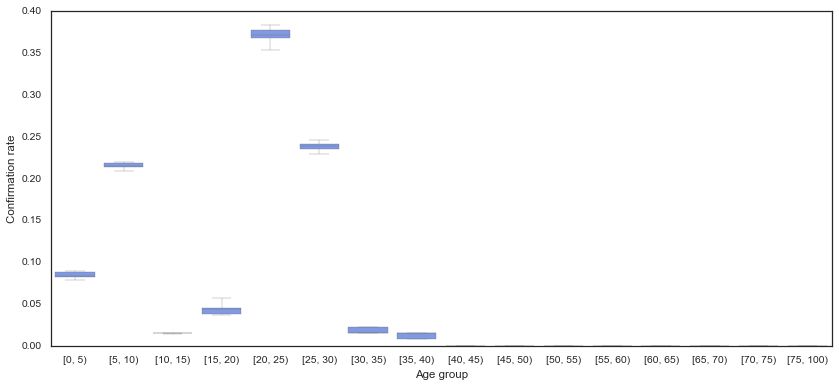

In [149]:
import seaborn as sb

p_age = pd.DataFrame(model_june.p_age.trace(), columns=age_groups)

f, axes = plt.subplots(figsize=(14,6))
sb.boxplot(data=p_age, linewidth=0.3, fliersize=0, ax=axes,
          color=sb.color_palette("coolwarm", 5)[0])
axes.set_ylabel('Confirmation rate')
axes.set_xlabel('Age group')

Proportion of population susceptible, June model.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


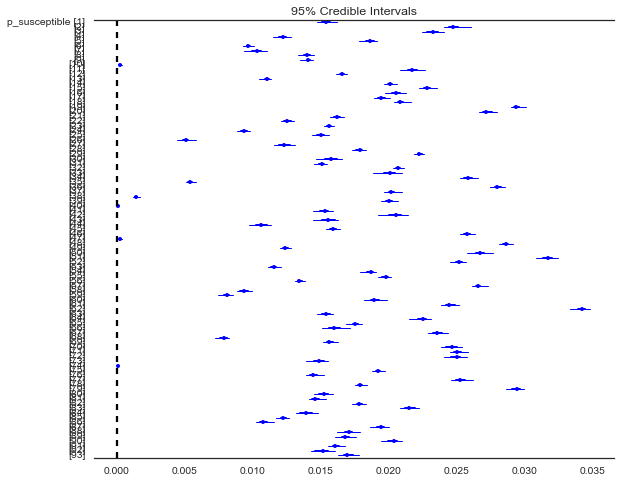

In [191]:
Matplot.summary_plot(model_june.p_susceptible)

Susceptibles at time 0 in each district, June model

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


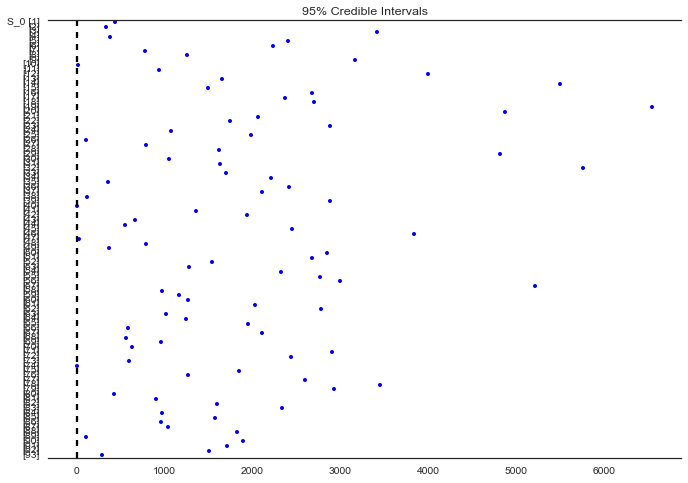

In [192]:
Matplot.summary_plot(model_june.S_0)

Proportion of population susceptible, June model with no confirmation correction

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


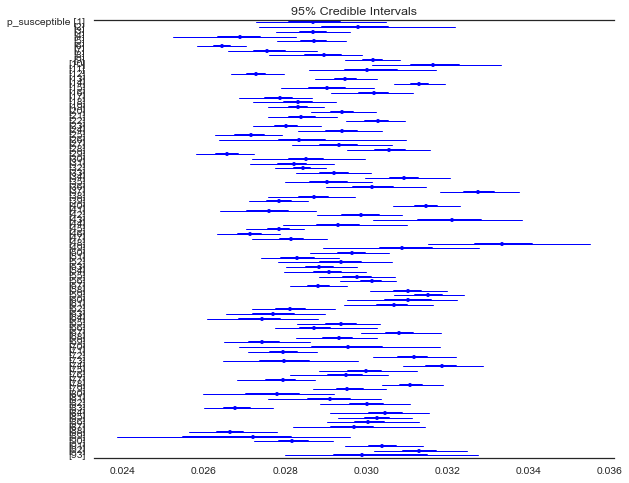

In [193]:
Matplot.summary_plot(model_june_noconf.p_susceptible)

In [155]:
Rt_june = model_june.Rt.stats()

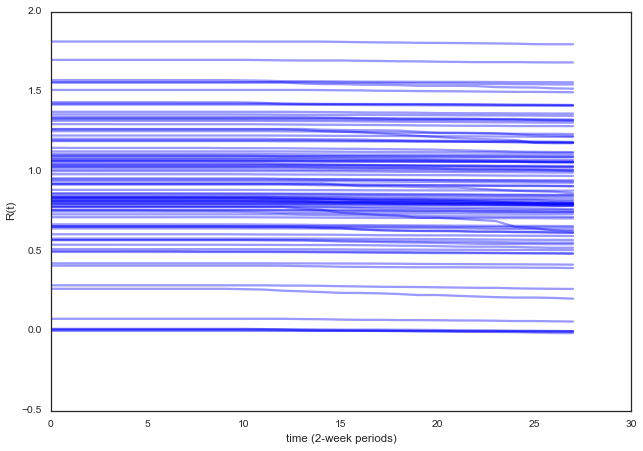

In [156]:
plt.plot(Rt_june['quantiles'][50].T, 'b-', alpha=0.4)
plt.ylabel('R(t)')
plt.xlabel('time (2-week periods)')

In [158]:
S_age_june = pd.DataFrame(model_june.S_age.trace().sum(1), columns=age_groups).unstack().reset_index()
S_age_june.columns = 'Age', 'Iteration', 'S'
S_age_june['Confirmation'] = 'Lab'

S_age_june_noconf = pd.DataFrame(model_june_noconf.S_age.trace().sum(1), columns=age_groups).unstack().reset_index()
S_age_june_noconf.columns = 'Age', 'Iteration', 'S'
S_age_june_noconf['Confirmation'] = 'Clinical'

S_age_june = pd.concat([S_age_june, S_age_june_noconf], ignore_index=True)

In [160]:
S_age_july = pd.DataFrame(model_july.S_age.trace().sum(1), columns=age_groups).unstack().reset_index()
S_age_july.columns = 'Age', 'Iteration', 'S'
S_age_july['Confirmation'] = 'Lab'

S_age_july_noconf = pd.DataFrame(model_july_noconf.S_age.trace().sum(1), columns=age_groups).unstack().reset_index()
S_age_july_noconf.columns = 'Age', 'Iteration', 'S'
S_age_july_noconf['Confirmation'] = 'Clinical'

S_age_july = pd.concat([S_age_july, S_age_july_noconf], ignore_index=True)

Numbers of suscepibles in each age group, under lab vs clinical confirmation

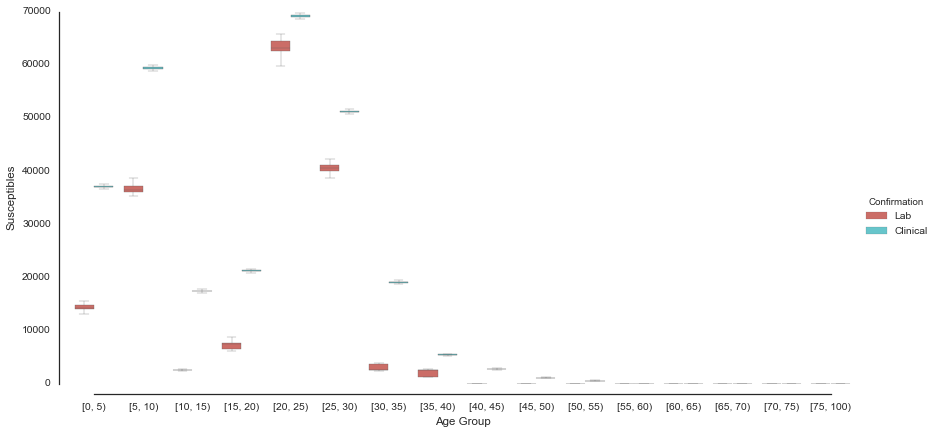

In [162]:
import seaborn as sb
sb.set_context("talk", font_scale=0.8)
sb.set_style("white")

g = sb.factorplot("Age", "S", "Confirmation", S_age_june, kind="box",
                   palette="hls", size=6, aspect=2, linewidth=0.3, fliersize=0)
g.despine(offset=10, trim=True)
g.set_axis_labels("Age Group", "Susceptibles");

In [163]:
june_Rt = pd.DataFrame(model_june.Rt_obs.trace()).unstack().reset_index()
june_Rt.columns = ('district', 'iteration', 'Rt')
june_Rt['month'] = 'June'

In [164]:
june_Rt_noconf = pd.DataFrame(model_june_noconf.Rt_obs.trace()).unstack().reset_index()
june_Rt_noconf.columns = ('district', 'iteration', 'Rt')
june_Rt_noconf['month'] = 'June'

In [165]:
july_Rt = pd.DataFrame(model_july.Rt_obs.trace()).unstack().reset_index()
july_Rt.columns = ('district', 'iteration', 'Rt')
july_Rt['month'] = 'July'

In [166]:
july_Rt_noconf = pd.DataFrame(model_july_noconf.Rt_obs.trace()).unstack().reset_index()
july_Rt_noconf.columns = ('district', 'iteration', 'Rt')
july_Rt_noconf['month'] = 'July'

In [167]:
confirmed_Rt = june_Rt.append(july_Rt, ignore_index=True)

In [168]:
june_means = june_Rt.groupby('district')['Rt'].mean()
june_means.sort(ascending=False)

In [169]:
sorted_districts = june_means.index.values

$R_{eff}$ by district in June and July (with lab confirmation), sorted by June means.

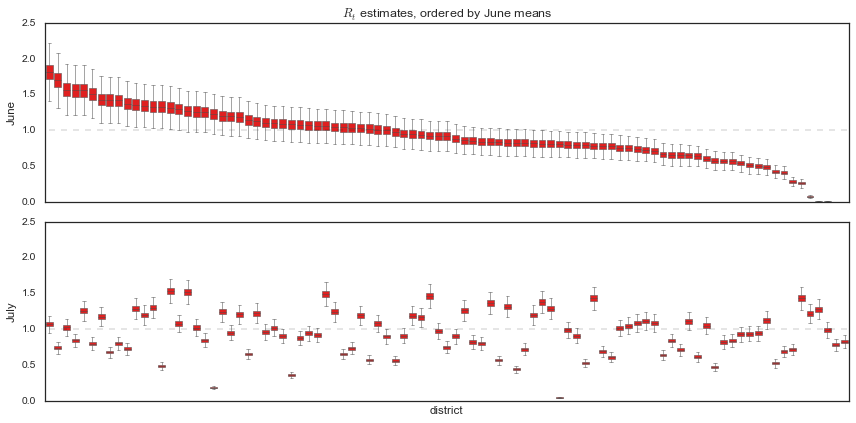

In [189]:
sb.set_context("talk", font_scale=0.8)

f, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(12,6), sharey=True, sharex=True)

sb.boxplot('district', 'Rt', data=june_Rt, ax=ax_1, linewidth=0.5, 
           fliersize=0, color='r', order=sorted_districts)
ax_1.hlines(1, xmin=0, xmax=93, linestyles='dashed', linewidth=0.2)
ax_1.set_xticks([])
ax_1.set_xlabel('')
ax_1.set_ylabel('June')
#ax_1.set_ylim(0, 6)
#ax_1.set_yticks(range(7))
ax_1.set_title(r'$R_t$ estimates, ordered by June means')

sb.boxplot('district', 'Rt', data=july_Rt, ax=ax_2, linewidth=0.5, 
           fliersize=0, color='r', order=sorted_districts)
ax_2.hlines(1, xmin=0, xmax=93, linestyles='dashed', linewidth=0.2)
ax_2.set_xticks([])
ax_2.set_ylabel('July')

f.tight_layout()

$R_{eff}$ by district in June for lab-confirmed and clinical-confirmed, sorted by lab-confirmed means.

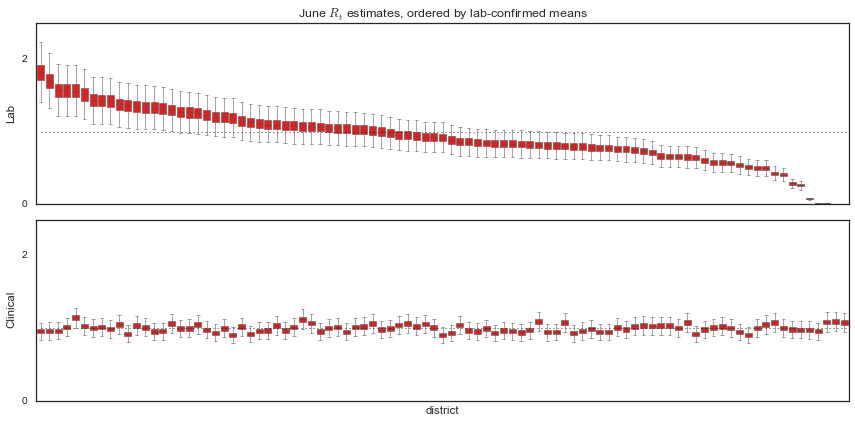

In [190]:
f, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(12,6), sharey=True, sharex=True)

sb.boxplot('district', 'Rt', data=june_Rt, ax=ax_1, linewidth=0.5, 
           fliersize=0, color='r', order=june_means.index.values)
ax_1.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_1.set_xticks([])
ax_1.set_xlabel('')
ax_1.set_ylabel('Lab')
ax_1.set_yticks(np.arange(13, step=2))
ax_1.set_title(r'June $R_t$ estimates, ordered by lab-confirmed means')

sb.boxplot('district', 'Rt', data=june_Rt_noconf, ax=ax_2, linewidth=0.5, 
           fliersize=0, color='r', order=june_means.index.values)
ax_2.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_2.set_xticks([])
ax_2.set_ylabel('Clinical')

f.tight_layout()

$R_{eff}$ by district in July for lab-confirmed and clinical-confirmed, sorted by lab-confirmed means.

In [172]:
july_means = july_Rt.groupby('district')['Rt'].mean()
july_means.sort(ascending=False)

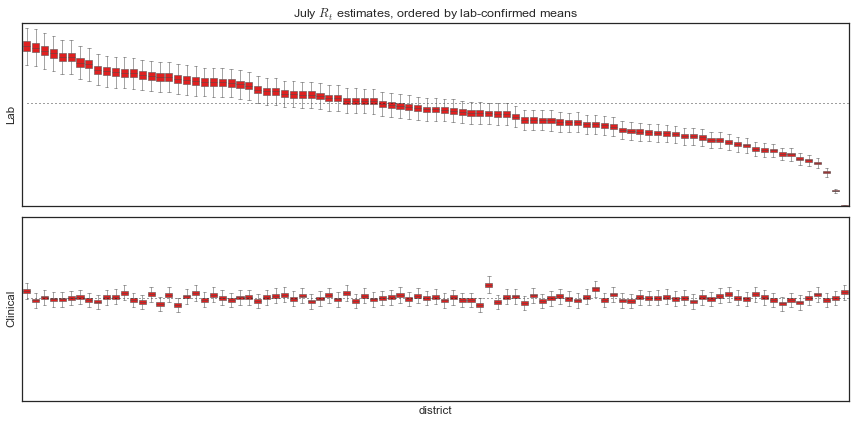

In [173]:
f, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(12,6), sharey=True, sharex=True)

sb.boxplot('district', 'Rt', data=july_Rt, ax=ax_1, linewidth=0.5, 
           fliersize=0, color='r', order=july_means.index.values)
ax_1.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_1.set_xticks([])
ax_1.set_xlabel('')
ax_1.set_ylabel('Lab')
ax_1.set_yticks(np.arange(13, step=2))
ax_1.set_title(r'July $R_t$ estimates, ordered by lab-confirmed means')

sb.boxplot('district', 'Rt', data=july_Rt_noconf, ax=ax_2, linewidth=0.5, 
           fliersize=0, color='r', order=sorted_districts)
ax_2.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_2.set_xticks([])
ax_2.set_ylabel('Clinical')

f.tight_layout()

In [174]:
model_june.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.08             0.005            0.0                [ 0.07  0.09]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.07             0.076           0.08           0.083         0.09
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.3              0.01             0.001            [ 0.281  0.318]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.282            0.293           0.299          0.306         0.319
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	--------------------

In [175]:
june_coverage = pd.DataFrame({name: model_june.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_coverage['Month'] = 'June'
june_coverage['Confirmation'] = 'Lab'

june_noconf_coverage = pd.DataFrame({name: model_june_noconf.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_noconf_coverage['Month'] = 'June'
june_noconf_coverage['Confirmation'] = 'Clinical'

july_coverage = pd.DataFrame({name: model_july.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_coverage['Month'] = 'July'
july_coverage['Confirmation'] = 'Lab'

july_noconf_coverage = pd.DataFrame({name: model_july_noconf.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_noconf_coverage['Month'] = 'July'
july_noconf_coverage['Confirmation'] = 'Clinical'

In [176]:
coverage = pd.concat([june_coverage, june_noconf_coverage, july_coverage, july_noconf_coverage], 
                     ignore_index=True)

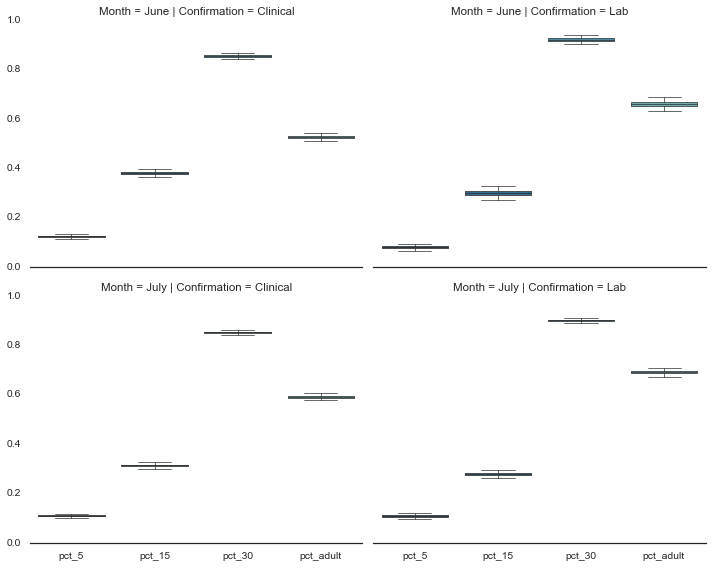

In [177]:
sb.factorplot(row="Month", col="Confirmation", data=coverage, kind='box',
              row_order=['June', 'July'],
              order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'],
               palette="YlGnBu_d", linewidth=0.7, fliersize=0, aspect=1.25).despine(left=True)

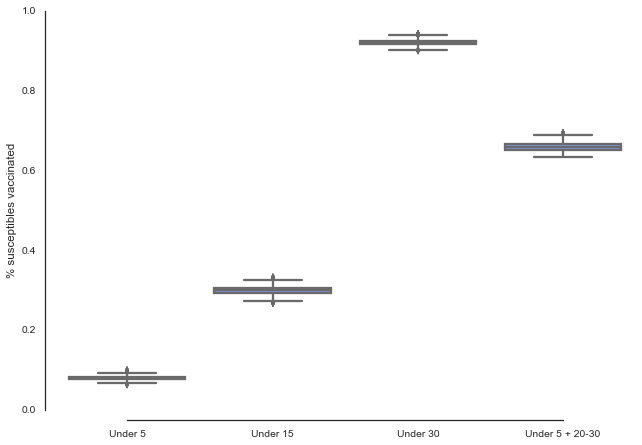

In [178]:
axes = sb.boxplot(data=june_coverage, order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'], 
                  color=sb.color_palette("coolwarm", 5)[0])
axes.set_xticklabels(['Under 5', 'Under 15', 'Under 30', 'Under 5 + 20-30'])
axes.set_ylabel('% susceptibles vaccinated')
sb.despine(offset=10, trim=True)

In [179]:
model_june_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.124            0.004            0.0              [ 0.116  0.131]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.116            0.121           0.124          0.127         0.132
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.38             0.006            0.0              [ 0.369  0.393]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.368            0.376           0.38           0.384         0.393
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [180]:
model_july.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.107            0.005            0.0              [ 0.096  0.116]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.096            0.104           0.107          0.111         0.117
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.277            0.006            0.0              [ 0.265  0.291]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.264            0.273           0.277          0.282         0.29
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	--------------------

In [181]:
model_july_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.109            0.003            0.0              [ 0.102  0.116]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.102            0.107           0.109          0.112         0.116
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.313            0.005            0.0              [ 0.303  0.323]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.303            0.31            0.313          0.317         0.323
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [182]:
Rt_july = model_july.Rt.stats()

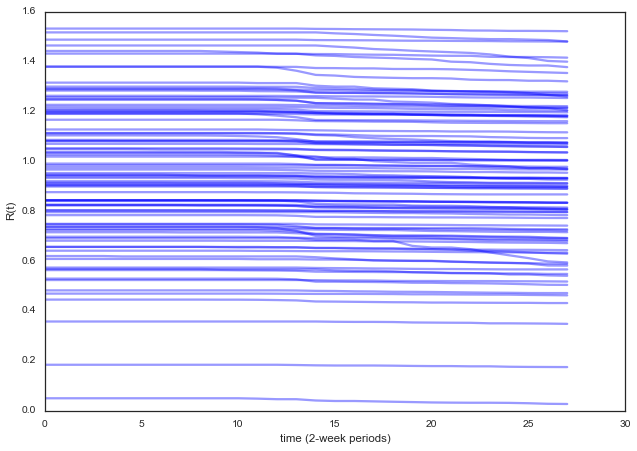

In [183]:
plt.plot(Rt_july['quantiles'][50].T, 'b-', alpha=0.4)
plt.ylabel('R(t)')
plt.xlabel('time (2-week periods)')

In [184]:
Rt_june_noconf = model_june_noconf.Rt.stats()

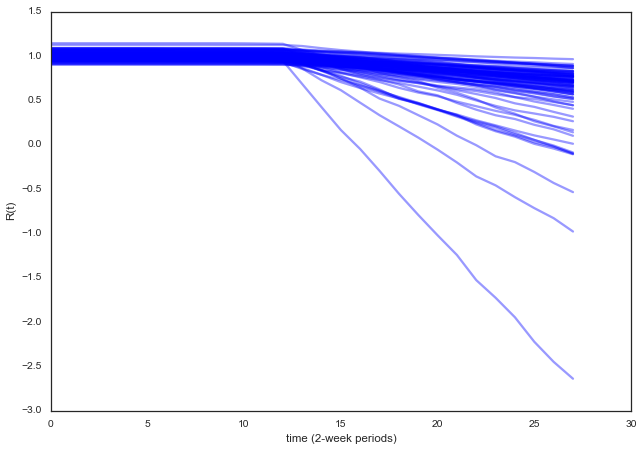

In [185]:
plt.plot(Rt_june_noconf['quantiles'][50].T, 'b-', alpha=0.4)
plt.ylabel('R(t)')
plt.xlabel('time (2-week periods)')

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


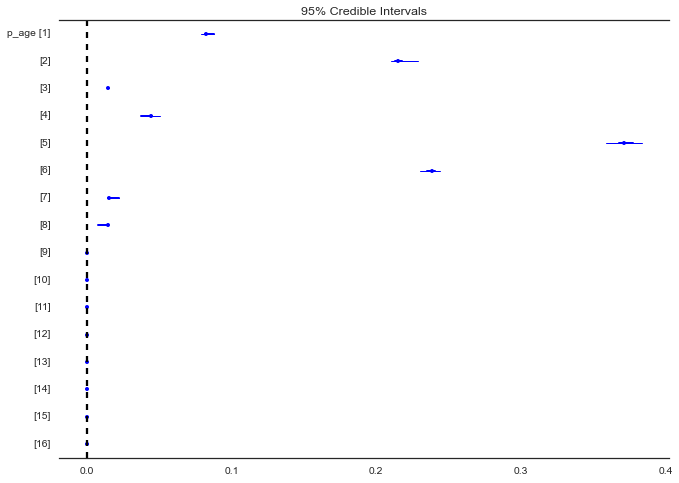

In [186]:
Matplot.summary_plot(model_june.p_age)

In [187]:
june_age_dist = model_june.age_dist.trace()[:]
june_age_dist.shape

AttributeError: 'MCMC' object has no attribute 'age_dist'

In [ ]:
june_age_dist = pd.DataFrame(june_age_dist, columns=measles_data['AGE_GROUP'].unique())

In [ ]:
plt.figure(figsize=(8,12))
Matplot.summary_plot(model_july.vaccination_target)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


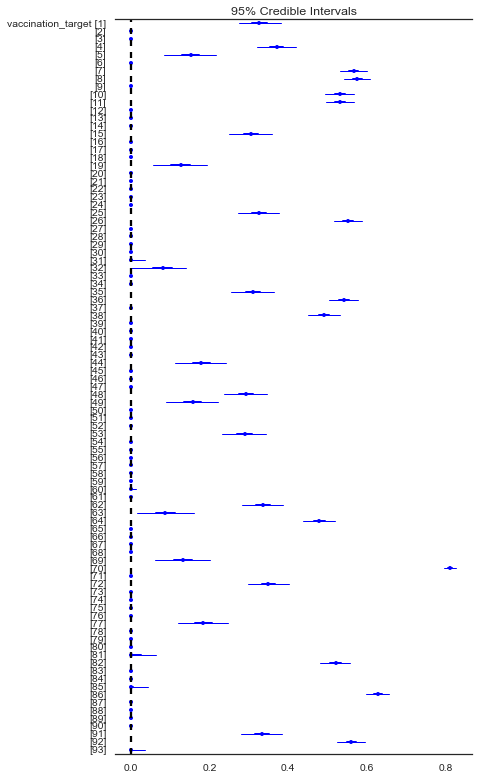

In [175]:
plt.figure(figsize=(8,12))
Matplot.summary_plot(model_july.vaccination_target)

## Mapping spatial effects

In [176]:
from mpl_toolkits.basemap import Basemap
import geopandas as gpd

lllat=-24
urlat=-23.3
lllon=-47
urlon=-46.3

SP_base = Basemap(ax=None, lon_0=(urlon + lllon) / 2, lat_0=(urlat + lllat) / 2,
        llcrnrlat=lllat, urcrnrlat=urlat, llcrnrlon=lllon, urcrnrlon=urlon, 
                  resolution='i',
                 epsg='4326')

In [177]:
SP_dist = gpd.GeoDataFrame.from_file('Sao Paulo/Brazil_full/BRA_adm3.shp').to_crs({'proj': 'longlat', 
                                                                               'ellps': 'WGS84', 
                                                                               'datum': 'WGS84'})

In [178]:
SP_dist['DIST_NAME'] = [trans.trans(_).upper() for _ in SP_dist.NAME_3]

In [179]:
SP_dist.head()

,ENGTYPE_3,HASC_3,ID_0,ID_1,ID_2,ID_3,ISO,NAME_0,NAME_1,NAME_2,...,NL_NAME_3,REMARKS_3,Shape_Area,Shape_Leng,TYPE_3,VALIDFR_3,VALIDTO_3,VARNAME_3,geometry,DIST_NAME
0,District,None,32,434,4112,4868,BRA,Brazil,Bahia,Piritiba,...,None,None,0.041872,1.033621,Distrito,Unknown,Present,None,POLYGON ((-40.38711999999998 -11.6031739999999...,PIRITIBA
1,District,None,32,434,4112,4869,BRA,Brazil,Bahia,Piritiba,...,None,None,0.008318,0.375198,Distrito,Unknown,Present,None,POLYGON ((-40.62181199999998 -11.7807669999999...,PORTO FELIZ
2,District,None,32,434,4113,4870,BRA,Brazil,Bahia,Planaltino,...,None,None,0.024796,0.751948,Distrito,Unknown,Present,None,POLYGON ((-40.11320899999998 -13.3009799999998...,IBITIGUIRA
3,District,None,32,434,4113,4871,BRA,Brazil,Bahia,Planaltino,...,None,None,0.027577,0.776489,Distrito,Unknown,Present,None,POLYGON ((-40.15503999999993 -13.1252719999998...,NOVA ITAIPE
4,District,None,32,434,4113,4872,BRA,Brazil,Bahia,Planaltino,...,None,None,0.025845,1.052880,Distrito,Unknown,Present,None,POLYGON ((-40.38104599999997 -13.2141219999999...,PLANALTINO


In [180]:
SP_dist.NAME_3.unique()

array(['Piritiba', 'Porto Feliz', 'Ibitiguira', ..., 'Tupiratins',
       'Wanderlândia', 'Xambioá'], dtype=object)

In [181]:
district_names

array(['BRAS', 'BARRA FUNDA', 'FREGUESIA DO O', 'CAMBUCI', 'PENHA',
       'BRAZILANDIA', 'SANTA CECILIA', 'CASA VERDE', 'CAPAO REDONDO',
       'CONSOLACAO', 'JAGUARE', 'CIDADE ADEMAR', 'CIDADE TIRADENTES',
       'SAPOPEMBA', 'MOOCA', 'CANGAIBA', 'SAUDE', 'SANTANA',
       'JARDIM ANGELA', 'CAMPO LIMPO', 'VILA MARIANA', 'VILA CURUCA',
       'CIDADE DUTRA', 'ARTUR ALVIM', 'JARDIM HELENA', 'SE', 'LAPA',
       'JARDIM PAULISTA', 'JABAQUARA', 'PINHEIROS', 'RIO PEQUENO',
       'GRAJAU', 'VILA SONIA', 'IGUATEMI', 'SANTO AMARO', 'LIMAO',
       'PERDIZES', 'SAO DOMINGOS', 'SAO LUCAS', 'PIRITUBA',
       'RAPOSO TAVARES', 'VILA FORMOSA', 'BELEM', 'REPUBLICA',
       'SAO MATEUS', 'TREMEMBE', 'VILA PRUDENTE', 'VILA LEOPOLDINA',
       'BOM RETIRO', 'JOSE BONIFACIO', 'PARELHEIROS', 'PERUS', 'PEDREIRA',
       'JARAGUA', 'LAJEADO', 'SACOMA', 'ITAIM PAULISTA', 'TUCURUVI',
       'VILA MEDEIROS', 'LIBERDADE', 'TATUAPE', 'CARRAO', 'BELA VISTA',
       'BUTANTA', 'SAO RAFAEL', 'MORUMBI', 'AGUA R

In [182]:
Rt_june = pd.Series(model_june.Rt_obs.stats()['mean'], index=sp_districts)

In [183]:
Rt_june

BRAS              2.421699
BARRA FUNDA       4.627280
FREGUESIA DO O    0.120166
CAMBUCI           3.232438
PENHA             0.847134
BRAZILANDIA       0.252696
SANTA CECILIA     0.608860
CASA VERDE        0.430532
CAPAO REDONDO     0.586295
CONSOLACAO        1.518891
...
CIDADE LIDER      0.310044
CAMPO BELO        0.391562
VILA JACUI        0.169532
ITAIM BIBI        1.271748
VILA GUILHERME    0.147772
CURSINO           0.462716
MARSILAC          3.361098
GUAIANASES        0.292970
VILA MATILDE      0.404423
PONTE RASA        0.304267
PARI              1.585863
Length: 93, dtype: float64

In [184]:
SP_dist_merged = SP_dist.merge(pd.DataFrame(Rt_june, columns=['Rt']), left_on='DIST_NAME', right_index=True)

In [185]:
SP_dist_merged = SP_dist.merge(foo, left_on='DIST_NAME', right_index=True)

NameError: name 'foo' is not defined

In [ ]:
measles_onset_conf = measles_data[CONFIRMED].groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0).sum()

In [ ]:
measles_onset_conf

In [ ]:
_rates = measles_onset_conf/sp_pop.sum(1)

In [ ]:
SP_dist_conf = SP_dist.merge(pd.DataFrame(_rates, columns=['rate']), left_on='DIST_NAME', right_index=True)

In [ ]:
from matplotlib.pyplot import cm

map_fig = plt.figure(figsize=(16,12))
map_ax = plt.gca()
SP_base.drawcoastlines()
SP_base.drawrivers()

SP_dist_merged.plot(column='cases', colormap=cm.Reds, axes=map_ax)